# 3. Regression
In this notebook we will finally run our regression models. For that purpose, we are importing the necessary libraries and functions from our ```modules``` folder. We are also importing our extracted dataframe

In [1]:
# Warnings
import warnings
warnings.filterwarnings("ignore")

# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from scipy import stats
from functools import reduce

# Statsmodels
import statsmodels.api as sm
import pmdarima as pmd
from pmdarima.arima import auto_arima
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Machine Learning models
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Ridge, Lasso, ElasticNet, ElasticNetCV, LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    r2_score,
    precision_score

)

from xgboost import XGBRegressor



In [2]:
# We import our own functions
import sys
sys.path.append('../../..')  # Move two levels up to the project root
from modules.functions import *

In [3]:
df = pd.read_csv('../../../input/df_raw_test.csv', parse_dates=['Fecha'], index_col='Fecha')
df.tail()

,CPI,Monetary Policy Rate,Exchange rate,Circulating Currency Seasonally Adjusted (mill S/),Net International Reserves (mill $),Real Minimum Wage (Index),Wheat (US$ per ton),Corn (US$ per ton),Soybean oil (US$ per ton),Crude oil (US$ per barrel)
Fecha,,,,,,,,,,
2023-08-01,0.182324,7.75,3.697768,11.194037,11.182374,5.646268,5.714305,5.288844,7.354495,4.399204
2023-09-01,0.133933,7.50,3.730995,11.196305,11.173721,5.646104,5.677783,5.178940,7.283402,4.490772
2023-10-01,0.085365,7.25,3.845759,11.202967,11.172515,5.649334,5.548594,5.191875,7.138916,4.448655
2023-11-01,0.036736,7.00,3.760795,11.200187,11.180961,5.650966,5.567082,5.146240,7.076030,4.351357
2023-12-01,-0.011845,6.75,3.733942,11.186627,11.170900,5.646966,5.599153,5.145342,7.046320,4.276196


In [4]:
df_lags = pd.read_csv('../../../input/df_lags_test.csv', parse_dates=['Fecha'], index_col='Fecha')
df_lags.tail()

,CPI,Monetary Policy Rate_lag_1,Monetary Policy Rate_lag_2,Monetary Policy Rate_lag_3,Monetary Policy Rate_lag_4,Exchange rate_lag_1,Exchange rate_lag_2,Exchange rate_lag_3,Exchange rate_lag_4,Circulating Currency Seasonally Adjusted (mill S/)_lag_1,...,Corn (US$ per ton)_lag_3,Corn (US$ per ton)_lag_4,Soybean oil (US$ per ton)_lag_1,Soybean oil (US$ per ton)_lag_2,Soybean oil (US$ per ton)_lag_3,Soybean oil (US$ per ton)_lag_4,Crude oil (US$ per barrel)_lag_1,Crude oil (US$ per barrel)_lag_2,Crude oil (US$ per barrel)_lag_3,Crude oil (US$ per barrel)_lag_4
Fecha,,,,,,,,,,,,,,,,,,,,,
2023-08-01,0.182324,7.75,7.75,7.75,7.75,3.601255,3.650419,3.688668,3.765450,11.196625,...,5.461808,5.531248,7.342273,7.158705,7.063081,7.124298,4.327658,4.253043,4.271259,4.375870
2023-09-01,0.133933,7.75,7.75,7.75,7.75,3.697768,3.601255,3.650419,3.688668,11.194037,...,5.487035,5.461808,7.354495,7.342273,7.158705,7.063081,4.399204,4.327658,4.253043,4.271259
2023-10-01,0.085365,7.50,7.75,7.75,7.75,3.730995,3.697768,3.601255,3.650419,11.196305,...,5.368204,5.487035,7.283402,7.354495,7.342273,7.158705,4.490772,4.399204,4.327658,4.253043
2023-11-01,0.036736,7.25,7.50,7.75,7.75,3.845759,3.730995,3.697768,3.601255,11.202967,...,5.288844,5.368204,7.138916,7.283402,7.354495,7.342273,4.448655,4.490772,4.399204,4.327658
2023-12-01,-0.011845,7.00,7.25,7.50,7.75,3.760795,3.845759,3.730995,3.697768,11.200187,...,5.178940,5.288844,7.076030,7.138916,7.283402,7.354495,4.351357,4.448655,4.490772,4.399204


In [5]:
df = df[:'2022-12-01']
df_lags = df_lags[:'2022-12-01'] 

## 3.1 Benchmark models

In the first section, we first run our benchmark econometric models: ```Random Walk (RW)```,  ```Autoregressive Integrated Moving Average (ARIMA)``` and ```Vector Autoregression (VAR)``` processes

### 3.1.1 Random Walk (RW)

In [6]:
forecast_horizons = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# We define our target variable
target = 'CPI'

# We only use CPI as Random Walk is an univariate process
df_CPI = pd.DataFrame(df_lags.CPI)

# We create our train and test set
train_set = df_CPI[df_CPI.index < '2022-01-01']
test_set  = df_CPI[df_CPI.index >= '2022-01-01']

predictions = {}

for h in forecast_horizons:
    # We get the values h horizons before
    predicted_value = train_set.iloc[-1, 0] 

    # We save it for horizon h
    predictions[h] = predicted_value

predicted = pd.DataFrame([predictions]).transpose().reset_index()

predicted.columns = ['Horizon', 'Prediction']

predicted = predicted.set_index(test_set.index)

predicted

,Horizon,Prediction
Fecha,,
2022-01-01,1,0.647889
2022-02-01,2,0.647889
2022-03-01,3,0.647889
2022-04-01,4,0.647889
2022-05-01,5,0.647889
2022-06-01,6,0.647889
2022-07-01,7,0.647889
2022-08-01,8,0.647889
2022-09-01,9,0.647889


In [7]:
# We create our results dataframe, concatenating the predicted and the actual values
results_rw = pd.concat([predicted, test_set[target]], axis=1)
results_rw.rename(columns={'Horizon': 'Horizon', 'Prediction': 'Predicted', 'CPI': 'Actual'}, inplace=True)
results_rw

,Horizon,Predicted,Actual
Fecha,,,
2022-01-01,1,0.647889,0.667520
2022-02-01,2,0.647889,0.677191
2022-03-01,3,0.647889,0.679208
2022-04-01,4,0.647889,0.678106
2022-05-01,5,0.647889,0.677198
2022-06-01,6,0.647889,0.677019
2022-07-01,7,0.647889,0.676201
2022-08-01,8,0.647889,0.671428
2022-09-01,9,0.647889,0.658650


In [8]:
# We get our metrics using our function
RMSE_rw, MAPE_rw = get_metrics(results_rw, 'RW')
metrics_rw = pd.concat([RMSE_rw, MAPE_rw], axis = 1)
metrics_rw

,RMSE_RW,MAPE_RW
1,0.019631,0.029409
2,0.024940,0.036339
3,0.027233,0.039596
4,0.028009,0.040838
5,0.028274,0.041326
6,0.028418,0.041610
7,0.028403,0.041647
8,0.027841,0.040823
9,0.026493,0.038102
10,0.025448,0.036277


### 3.1.2 Autoregressive Integrated Moving Average (ARIMA)

In [9]:
# # We only use CPI as Random Walk is an univariate process
# df_CPI = pd.DataFrame(df_lags.CPI)

# # We create our train and test set
# train_set = df_CPI[df_CPI.index < '2022-01-01']
# test_set  = df_CPI[df_CPI.index >= '2022-01-01']

In [10]:
# # We find the best SARIMA model
# autoarima = pmd.auto_arima(
#         y = train_set,
#         start_p=1,
#         start_q=0,
#         seasonal=True,
#         max_p=12,
#         max_d=1,
#         max_q=6,
#         max_P=12,
#         max_D=1,
#         max_Q=6,
#         m=4,
#         n_jobs=-1,
#         suppress_warnings=True,
#         )

# # We indicate the seasonal order for monthly data
# seasonal_order = (1, 1, 1, 12)

# # We create our ARIMA model
# model = SARIMAX(train_set,
#                 order=autoarima.order,
#                 seasonal_order=autoarima.seasonal_order,
#                 enforce_stationarity = False,
#                 enforce_invertibility = False)
        
# # We fit the model
# model_fit = model.fit()

# # We forecast for the next 12 horizons
# forecast_values = model_fit.get_forecast(steps=12)
# predicted = pd.DataFrame(forecast_values.predicted_mean, index = test_set.index)

# # We create our results dataframe, concatenating the predicted and the actual values
# results = pd.concat([predicted, test_set[target]], axis=1)
# results.rename(columns={'predicted_mean': 'Predicted', 'CPI': 'Actual'}, inplace=True)
# results

In [11]:
# We get our metrics using our function
# RMSE_arima, MAPE_arima = get_metrics(results, 'ARIMA')
# metrics_arima= pd.concat([RMSE_arima, MAPE_arima], axis = 1)
# metrics_arima

### 3.1.3 Vector autoregression (VAR)

In [12]:
# We define our target variable, as well as our train and test set
target = 'CPI'
train_set = df[df.index < '2022-01-01']
test_set  = df[df.index >= '2022-01-01']

In [13]:
# We model our VAR including up to two lags
model_var = VAR(df)
model_fit = model_var.fit(4)

In [14]:
# Summary of the model
# model_fit.summary()

In [15]:
# We forecast for the next 12 months
preds = model_fit.forecast(df.values[-4:], 12)
preds = pd.DataFrame(preds, index = test_set[target].index)[0]

# We create our results dataframe, concatenating the predicted and the actual values
results_var = pd.concat([preds, test_set[target]],axis=1)
results_var.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_var

,Predicted,Actual
Fecha,,
2022-01-01,0.514527,0.667520
2022-02-01,0.469199,0.677191
2022-03-01,0.427543,0.679208
2022-04-01,0.391074,0.678106
2022-05-01,0.359860,0.677198
2022-06-01,0.333073,0.677019
2022-07-01,0.309501,0.676201
2022-08-01,0.288158,0.671428
2022-09-01,0.268600,0.658650


In [16]:
# We get our metrics using our function
RMSE_var, MAPE_var = get_metrics(results_var, 'VAR')
metrics_var= pd.concat([RMSE_var, MAPE_var], axis = 1)
metrics_var

,RMSE_VAR,MAPE_VAR
1,0.152993,0.229197
2,0.182576,0.268168
3,0.208169,0.302288
4,0.230429,0.332537
5,0.250238,0.359751
6,0.268140,0.384464
7,0.284319,0.407011
8,0.298487,0.427488
9,0.309999,0.445789
10,0.318214,0.461708


<Axes: >

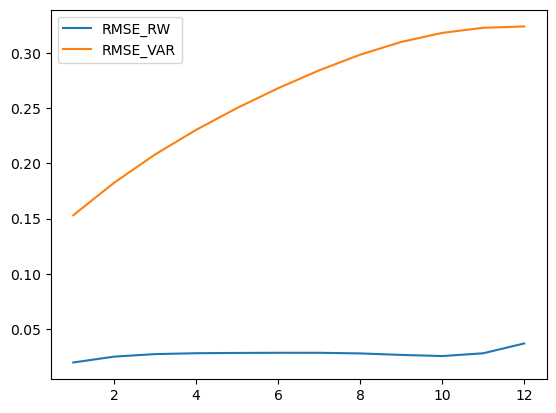

In [17]:
rmse_econometrics = pd.concat([RMSE_rw, RMSE_var], axis=1)

rmse_econometrics.plot()

## 3.2 Machine learning models

In the second section, we run our machine learning models: ```Ridge Regression (Ridge)```,  ```Least Absolute Shrinkage and Selection Operator (LASSO)``` and ```Random Forest (RF)``` models

### 3.2.1 Ridge Regression (Ridge)

In [18]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2022-01-01']
test_set  = df_lags[df_lags.index >= '2022-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
import sklearn.linear_model as skl
ridge = skl.ElasticNet(l1_ratio=0)
model = ridge

# We define out lambdas and implement our gridparams
lambdas    = np.linspace(0.1, 1, 1000)

grid_params = {'alpha': lambdas}

# We implement our gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')

grid_search.fit( X_train, y_train )

pd.DataFrame( grid_search.cv_results_ )

# And select out best model
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [19]:
pred_vars = X_train.columns.to_list()
coefficients = best_model.coef_
vars_df_ridge      = pd.DataFrame( {'Var': best_model.feature_names_in_, 'Coefficient': coefficients } )
vars_df_ridge      = vars_df_ridge.reindex( vars_df_ridge[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_ridge.to_excel( f'../../../output/3_Regression/h19_test/h19coef_ridge.xlsx' )

In [20]:
# We use the best model to predict
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)
y_pred

Fecha
2022-01-01    0.549956
2022-02-01    0.550482
2022-03-01    0.550137
2022-04-01    0.558523
2022-05-01    0.570874
2022-06-01    0.592849
2022-07-01    0.604138
2022-08-01    0.594889
2022-09-01    0.581661
2022-10-01    0.558274
2022-11-01    0.546335
2022-12-01    0.548855
dtype: float64

In [21]:
# And concatenate the results
results_ridge = pd.concat([y_pred, y_test],axis=1)
results_ridge.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_ridge

,Predicted,Actual
Fecha,,
2022-01-01,0.549956,0.667520
2022-02-01,0.550482,0.677191
2022-03-01,0.550137,0.679208
2022-04-01,0.558523,0.678106
2022-05-01,0.570874,0.677198
2022-06-01,0.592849,0.677019
2022-07-01,0.604138,0.676201
2022-08-01,0.594889,0.671428
2022-09-01,0.581661,0.658650


In [22]:
RMSE_ridge, MAPE_ridge = get_metrics(results_ridge, 'Ridge')

<Axes: >

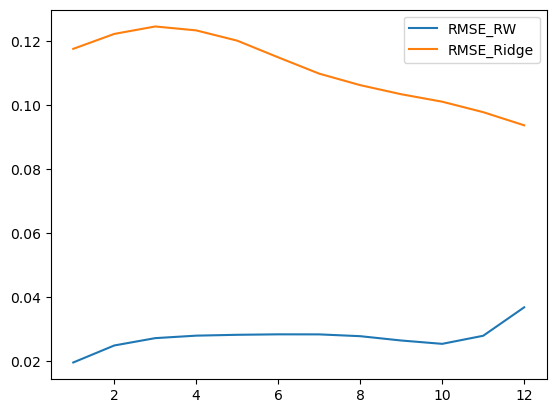

In [23]:
pd.concat([RMSE_rw, RMSE_ridge], axis=1).plot()

### 3.2.2 Lasso Regression (Lasso)

In [24]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2022-01-01']
test_set  = df_lags[df_lags.index >= '2022-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# We define the model
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.linear_model as skl
scaler = StandardScaler()

# Define model
model = Pipeline([
    ('scaler', scaler),
    ('regressor', ElasticNet(random_state=2024, l1_ratio=1))  
])

# Define grid search
grid_params = {
    'regressor__alpha': np.linspace(0.01, 10, 1000) 
}


# We implement the gridsearch
grid_search = GridSearchCV( model, grid_params, cv = tscv, scoring = 'neg_mean_squared_error')
grid_search.fit( X_train, y_train )
pd.DataFrame( grid_search.cv_results_ )

best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [25]:
pred_vars = X_train.columns.to_list()
coefficients = best_model.named_steps['regressor'].coef_
vars_df_lasso      = pd.DataFrame( {'Var': X_train.columns, 'Coefficient': coefficients } )
vars_df_lasso      = vars_df_lasso.reindex( vars_df_lasso[ 'Coefficient' ].abs().sort_values( ascending = False ).index )
vars_df_lasso.to_excel( f'../../../output/3_Regression/h19_test/h19coef_lasso.xlsx' )

In [26]:
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [27]:
results_lasso = pd.concat([y_pred, y_test],axis=1)
results_lasso.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_lasso

,Predicted,Actual
Fecha,,
2022-01-01,0.520217,0.667520
2022-02-01,0.511378,0.677191
2022-03-01,0.510751,0.679208
2022-04-01,0.535003,0.678106
2022-05-01,0.563269,0.677198
2022-06-01,0.583962,0.677019
2022-07-01,0.572844,0.676201
2022-08-01,0.552612,0.671428
2022-09-01,0.546321,0.658650


In [28]:
RMSE_lasso, MAPE_lasso = get_metrics(results_lasso, 'Lasso')

<Axes: >

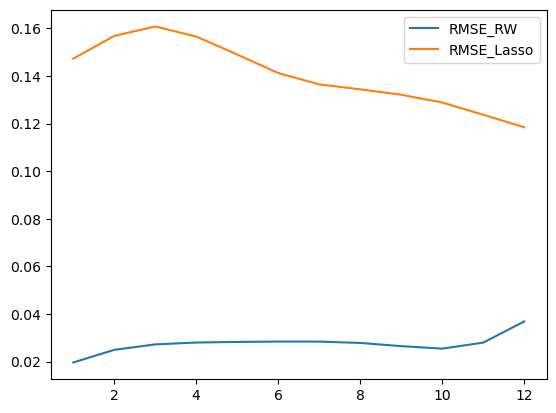

In [29]:
pd.concat([RMSE_rw, RMSE_lasso], axis=1).plot()

### 3.2.3 Random Forest Regression (Random Forest)

In [30]:
target = "CPI"
Y = pd.DataFrame(df_lags[target])
X = df_lags.drop(columns=[target])

train_set = df_lags[df_lags.index < '2022-01-01']
test_set  = df_lags[df_lags.index >= '2022-01-01']

y_train = train_set[target]
y_test  = test_set[target]
X_train = train_set.loc[:, train_set.columns != target]
X_test  = test_set.loc[:, test_set.columns != target]

# Implementing the temporal cross-validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size= 12)

# We implement the model
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor( random_state = 2024, n_jobs = -1 )
model = random_forest

# param_grid = {
#     'n_estimators': [100, 200, 500, 1000],  # Incrementado para explorar un mayor número de árboles
#     'max_features': ['auto', 'sqrt', 'log2'],  # Agregado 'log2' para considerar menos features por split
#     'max_depth': [10, 20, 30, None],  # Agregado None para permitir árboles completos
#     'min_samples_split': [2, 5, 10],  # Agregado 10 para ver el efecto de más restricciones en el split
#     'min_samples_leaf': [1, 2, 4]  # Agregado 4 para incrementar la generalización
# }

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}


grid_search = GridSearchCV( model, param_grid, cv = tscv, scoring = 'neg_mean_squared_error')
grid_search.fit( X_train, y_train )

pd.DataFrame( grid_search.cv_results_ )

# And select out best model
best_model  = grid_search.best_estimator_
best_params = grid_search.best_params_

In [31]:
best_params

{'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [32]:
pred_vars = X_train.columns.to_list()
feature_importances = best_model.feature_importances_
vars_df_rf             = pd.DataFrame( {'Var': pred_vars, 'Importance Score': feature_importances } )
vars_df_rf             = vars_df_rf.reindex(vars_df_rf[ 'Importance Score' ].abs().sort_values( ascending = False ).index )
vars_df_rf.to_excel( f'../../../output/3_Regression/h19_test/h19coef_rf.xlsx' )

In [33]:
y_pred = best_model.predict( X_test )
y_pred = pd.Series(y_pred, index = y_test.index)

In [34]:
results_rf = pd.concat([y_pred, y_test],axis=1)
results_rf.rename(columns={'CPI': 'Actual', 0: 'Predicted'}, inplace=True)
results_rf

,Predicted,Actual
Fecha,,
2022-01-01,0.596385,0.667520
2022-02-01,0.580276,0.677191
2022-03-01,0.572392,0.679208
2022-04-01,0.555661,0.678106
2022-05-01,0.545681,0.677198
2022-06-01,0.537371,0.677019
2022-07-01,0.518941,0.676201
2022-08-01,0.520415,0.671428
2022-09-01,0.524911,0.658650


In [35]:
RMSE_rf, MAPE_rf = get_metrics(results_rf, 'RF')

<Axes: >

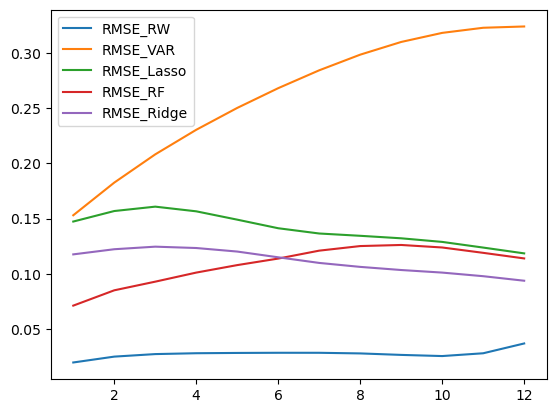

In [36]:
pd.concat([RMSE_rw, RMSE_var, RMSE_lasso, RMSE_rf, RMSE_ridge], axis=1).plot()

### 3.2.4 Random Forest Regression (validation test) -> best results so far -> try tomorrow with other models

## 3.3 Results
Here we concat all results into a single dataframe. We export the table to excel.


### 3.3.1 General results
Here we will create graphs and tables with the results of all models combined into a single datagrame.

In [52]:
RMSE_2022 = pd.concat([RMSE_rw, RMSE_var, RMSE_ridge, RMSE_lasso, RMSE_rf], axis=1)
MAPE_2022 = pd.concat([MAPE_rw, MAPE_var, MAPE_ridge, MAPE_lasso, MAPE_rf], axis=1)

In [53]:
RMSE_2022

,RMSE_RW,RMSE_VAR,RMSE_Ridge,RMSE_Lasso,RMSE_RF
1,0.019631,0.152993,0.117563,0.147303,0.071135
2,0.024940,0.182576,0.122222,0.156831,0.085008
3,0.027233,0.208169,0.124547,0.160800,0.092848
4,0.028009,0.230429,0.123325,0.156563,0.101063
5,0.028274,0.250238,0.120117,0.149015,0.107844
6,0.028418,0.268140,0.114909,0.141237,0.113764
7,0.028403,0.284319,0.109817,0.136471,0.120939
8,0.027841,0.298487,0.106229,0.134391,0.125094
9,0.026493,0.309999,0.103389,0.132122,0.126084
10,0.025448,0.318214,0.101061,0.128860,0.123803


<Axes: >

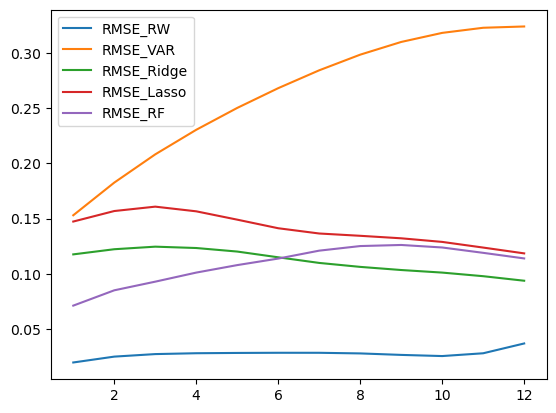

In [54]:
colors = {'RMSE_RW': 'tab:orange', 'RMSE_VAR': 'tab:blue', 'RMSE_Ridge': 'tab:green', 'RMSE_Lasso': 'tab:red', 'RMSE_RF': 'tab:purple'}

RMSE_2022.plot(label=colors)

In [55]:
RMSE_2022_results = RMSE_2022.div(RMSE_rw['RMSE_RW'], axis=0)
RMSE_2022_results = RMSE_2022_results.drop(columns=['RMSE_RW'])
RMSE_2022_results_highlight = RMSE_2022_results.style.apply(highlight_min, axis=1)
RMSE_2022_results_highlight

,RMSE_VAR,RMSE_Ridge,RMSE_Lasso,RMSE_RF
1,7.793480,5.988681,7.503595,3.623604
2,7.320705,4.900711,6.288417,3.408546
3,7.644126,4.573455,5.904686,3.409453
4,8.227087,4.403093,5.589822,3.608295
5,8.850584,4.248388,5.270486,3.814320
6,9.435543,4.043538,4.969982,4.003233
7,10.010217,3.866393,4.804822,4.257990
8,10.720986,3.815492,4.827014,4.493107
9,11.701145,3.902491,4.987023,4.759137
10,12.504591,3.971314,5.063690,4.864966


In [56]:
MAPE_2022_results = MAPE_2022.div(MAPE_rw['MAPE_RW'], axis=0)
MAPE_2022_results = MAPE_2022_results.drop(columns=['MAPE_RW'])
MAPE_2022_results_highlight = MAPE_2022_results.style.apply(highlight_min, axis=1)
MAPE_2022_results_highlight

,MAPE_VAR,MAPE_Ridge,MAPE_Lasso,MAPE_RF
1,7.793480,5.988681,7.503595,3.623604
2,7.379583,4.997767,6.405266,3.435395
3,7.634231,4.657510,6.006816,3.425771
4,8.142904,4.466524,5.660082,3.596643
5,8.705143,4.290813,5.288723,3.783180
6,9.239795,4.049304,4.927813,3.957386
7,9.772962,3.833301,4.744384,4.186769
8,10.471734,3.770856,4.776938,4.426012
9,11.699741,3.932064,5.046677,4.807261
10,12.727332,4.051097,5.180939,4.982418


In [57]:
tableH22 = RMSE_rw.join(RMSE_2022_results)
tableH22 = tableH22.rename(columns = {'RMSE_RW': 'Benchmark', 'RMSE_ARIMA': 'ARIMA', 'RMSE_VAR': 'VAR', 'RMSE_Ridge': 'Ridge', 
                            'RMSE_Lasso': 'Lasso', 'RMSE_RF':'RF'})
tableH22.index.name = 'horizon'
tableH22.to_excel("../../../output/3_Regression/h19_test/h22table_rmse.xlsx")

In [58]:
tableH22 = MAPE_rw.join(MAPE_2022_results)
tableH22 = tableH22.rename(columns = {'MAPE_RW': 'Benchmark', 'MAPE_ARIMA': 'ARIMA', 'MAPE_VAR': 'VAR', 'MAPE_Ridge': 'Ridge', 
                            'MAPE_Lasso': 'Lasso', 'MAPE_RF':'RF'})
tableH22.index.name = 'horizon'
tableH22.to_excel("../../../output/3_Regression/h19_test/h22table_mape.xlsx")

In [59]:
colors = {
    'RMSE_VAR': 'blue',   
    'RMSE_Ridge': 'green', 
    'RMSE_Lasso': 'red',  
    'RMSE_RF': 'purple'   
}

In [60]:
def graph_models(df_results, metric = "RMSE",lim=1.5, colors = None):
    '''
    Objective:
        This function graphs the errors (RMSE of MAPE) of the different models.
        
    Input:
        df_results (dataframe) = A dataframe
        
        lim (float)            = Indicates the limit of the y-axis

        colors (dict)          = A dictionary with column names as keys and colors as values
        
    Output:
        A matplotlib.pyplot plot      
    '''
    
    fig, ax = plt.subplots()

    for column in df_results.columns:
        if colors and column in colors:
            ax.plot(df_results.index, df_results[column], label=column, color=colors[column])
        else:
            # Plot with a default color if no color specified for a column
            ax.plot(df_results.index, df_results[column], label=column)
    
    ax.set_xlabel("Horizons")
    ax.set_ylabel(metric + ' as % of the benchmark')
    
    ax.set_ylim(0, lim)
    
    ax.legend()
    
    plt.show()

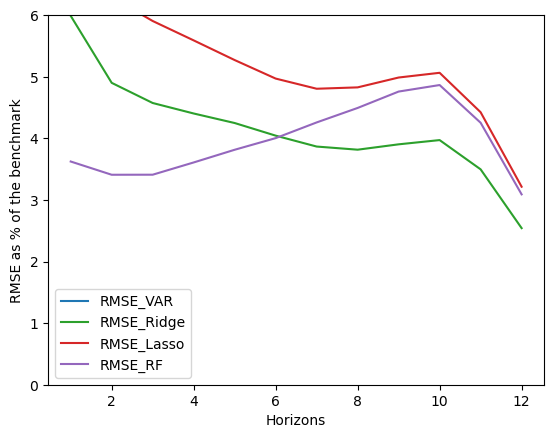

<Figure size 640x480 with 0 Axes>

In [72]:
colors = {'RMSE_VAR': 'tab:blue', 'RMSE_Ridge': 'tab:green', 'RMSE_Lasso': 'tab:red', 'RMSE_RF': 'tab:purple'}

graph_models(RMSE_2022_results, lim=6, colors=colors)

plt.savefig("../../../output/3_Regression/h19_test/h22_rmse.png", bbox_inches='tight', dpi=300)

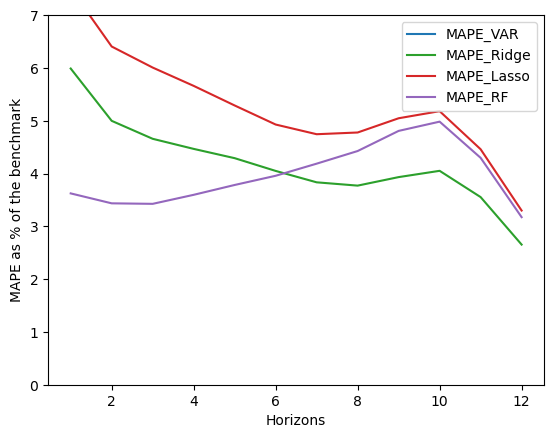

<Figure size 640x480 with 0 Axes>

In [71]:
colors = {'MAPE_VAR': 'tab:blue', 'MAPE_Ridge': 'tab:green', 'MAPE_Lasso': 'tab:red', 'MAPE_RF': 'tab:purple'}

graph_models(MAPE_2022_results, metric = "MAPE", lim=7, colors=colors)

plt.savefig("../../../output/3_Regression/h19_test/h22_mape.png", bbox_inches='tight', dpi=300)

### 3.3.2 Coefficients by model

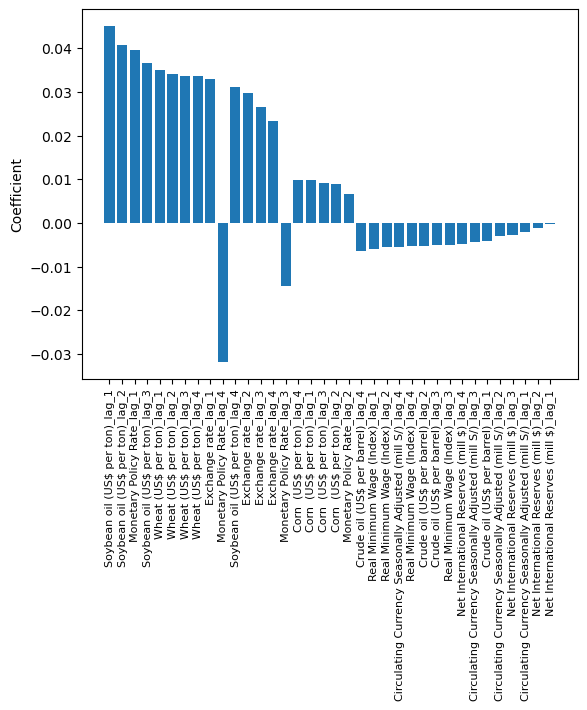

<Figure size 640x480 with 0 Axes>

In [63]:
graph_coefficients(vars_df_ridge, value = "Coefficient")

plt.savefig("../../../output/3_Regression/h19_test/h19_coef_ridge.png", bbox_inches='tight', dpi=300)

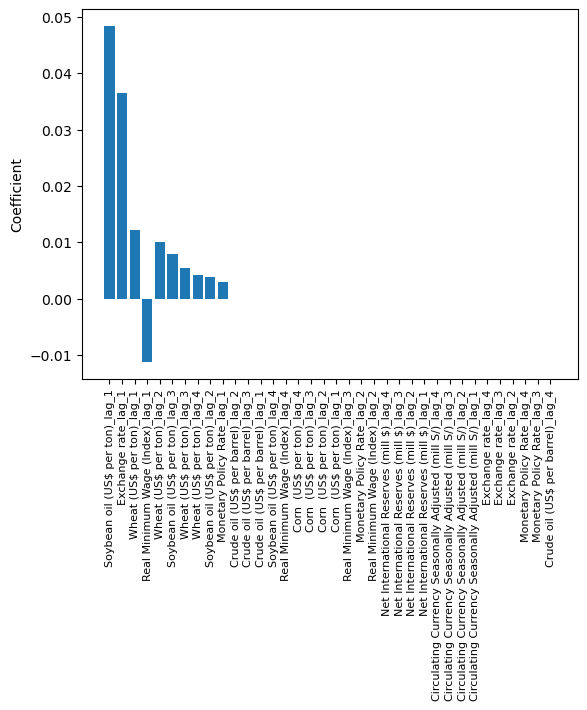

<Figure size 640x480 with 0 Axes>

In [64]:
graph_coefficients(vars_df_lasso, value = "Coefficient")

plt.savefig("../../../output/3_Regression/h19_test/h19_coef_lasso.png", bbox_inches='tight', dpi=300)

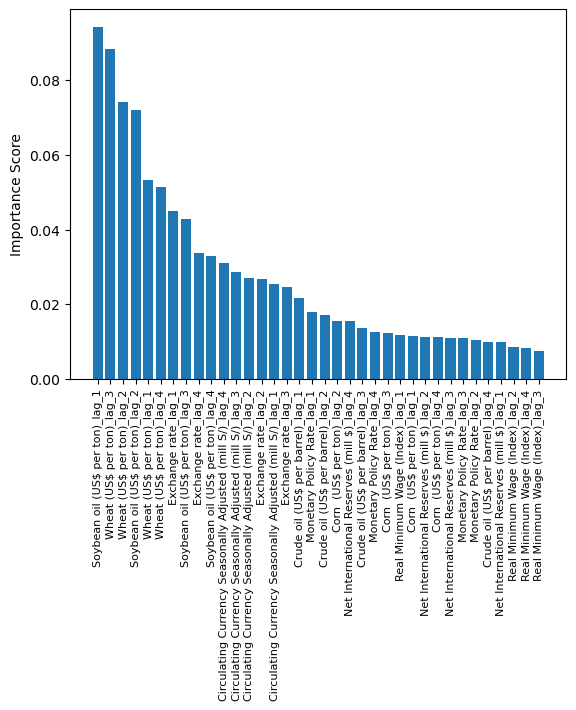

<Figure size 640x480 with 0 Axes>

In [65]:
graph_coefficients(vars_df_rf, value = "Importance Score")

plt.savefig("../../../output/3_Regression/h19_test/h19_coef_rf.png", bbox_inches='tight', dpi=300)

### 3.3.3 Prediction plots
We are going to plot our predictions in a single plot to compare visually how different models performed

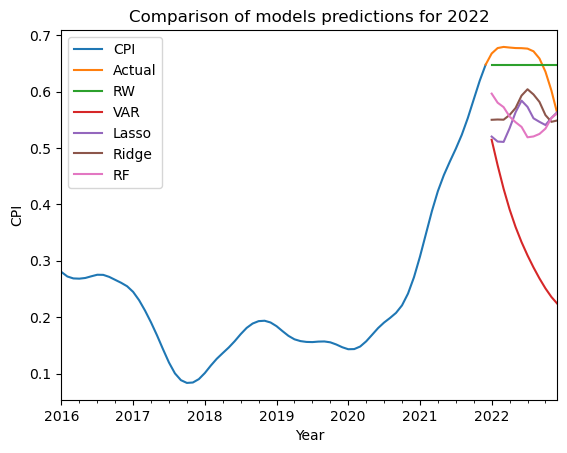

In [66]:
y_train['2016':].plot(label=None)
df['CPI']['2021-12-01':].plot(label='Actual')
results_rw['Predicted'].plot(label='RW')
results_var['Predicted'].plot(label='VAR')
results_lasso['Predicted'].plot(label='Lasso')
results_ridge['Predicted'].plot(label='Ridge')
results_rf['Predicted'].plot(label='RF')

plt.legend()

plt.title('Comparison of models predictions for 2022')
plt.xlabel('Year')
plt.ylabel('CPI')

plt.savefig('../../../output/3_Regression/h19_test/model_comparison_h22.png', bbox_inches='tight', dpi=300)

### 3.3.4 Dielbold-Mariano test
We implement the diebold-mariano test to see if the different in forecasts is statistically significant.

In [67]:
# RW - VAR
print('DM test for VAR:', dm_test(results_rw['Actual'], results_rw['Predicted'], results_var['Predicted'],  h = 3, crit="MSE"))

# RW - Ridge
print('DM test for Ridge: ', dm_test(results_rw['Actual'], results_rw['Predicted'], results_ridge['Predicted'],  h = 3, crit="MSE"))

# RW - Lasso
print('DM test for Lasso: ', dm_test(results_rw['Actual'], results_rw['Predicted'], results_lasso['Predicted'],  h = 3, crit="MSE"))

# RW - RF
print('DM test for RF: ', dm_test(results_rw['Actual'], results_rw['Predicted'], results_rf['Predicted'],  h = 3, crit="MSE"))

DM test for VAR: dm_return(DM=-3.6841089125888313, p_value=0.003599937019671877)
DM test for Ridge:  dm_return(DM=-1.884247044562133, p_value=0.0862163422266829)
DM test for Lasso:  dm_return(DM=-2.143803108679565, p_value=0.05523896020612091)
DM test for RF:  dm_return(DM=-2.2326811953927295, p_value=0.047303772842042936)


We conclude that
- The baseline model significantly outperforms each of the other more complex models, as evidenced by the very low p-value.